# Allineamento "Brute Force"

In [64]:
from collections import deque
from functools import partial

def all_alignments(x, y):
    """Return an iterable of all alignments of two
    sequences.

    x, y -- Sequences.
    """

    def F(x, y):
        """A helper function that recursively builds the
        alignments.

        x, y -- Sequence indices for the original x and y.
        """
        if len(x) == 0 and len(y) == 0:
            yield deque()

        scenarios = []
        if len(x) > 0 and len(y) > 0:
            scenarios.append((x[0], x[1:], y[0], y[1:]))
        if len(x) > 0:
            scenarios.append((x[0], x[1:], None, y))
        if len(y) > 0:
            scenarios.append((None, x, y[0], y[1:]))

        # NOTE: "xh" and "xt" stand for "x-head" and "x-tail",
        # with "head" being the front of the sequence, and
        # "tail" being the rest of the sequence. Similarly for
        # "yh" and "yt".
        for xh, xt, yh, yt in scenarios:
            for alignment in F(xt, yt):
                alignment.appendleft((xh, yh))
                yield alignment

    alignments = F(range(len(x)), range(len(y)))
    return map(list, alignments)

def print_alignment(x, y, alignment):
    print("".join(
        "-" if i is None else x[i] for i, _ in alignment
    ))
    print("".join(
        "-" if j is None else y[j] for _, j in alignment
    ))

def alignment_score(x, y, alignment):
    """Score an alignment.

    x, y -- sequences.
    alignment -- an alignment of x and y.
    """
    score_gap = -1
    score_same = +1
    score_different = -1

    score = 0
    for i, j in alignment:
        if (i is None) or (j is None):
            score += score_gap
        elif x[i] == y[j]:
            score += score_same
        elif x[i] != y[j]:
            score += score_different

    return score

def align_bf(x, y):
    """Align two sequences, maximizing the
    alignment score, using brute force.

    x, y -- sequences.
    """
    return max(
        all_alignments(x, y),
        key=partial(alignment_score, x, y),
    )

In [72]:
np.random.seed(1234)

n_brute = []
t_brute = []

for i in range(20 + 1):
    i+=1

    x = np.random.choice(['A', 'T', 'G', 'C'], i)
    y = np.random.choice(['A', 'T', 'G', 'C'], i)
    print(x,y)
    import time
    start = time.time()
    print_alignment(x, y, align_bf(x, y))
    stop = time.time()
    print("time: %0.3f" % (stop-start))
    
    n_brute.append(i)
    t_brute.append(stop-start)

['C'] ['C']
C
C
time: 0.000
['G' 'T'] ['A' 'A']
GT
AA
time: 0.000
['A' 'T' 'C'] ['T' 'C' 'T']
ATC-
-TCT
time: 0.000
['G' 'G' 'C' 'G'] ['A' 'A' 'G' 'G']
G-GCG
AAG-G
time: 0.002
['G' 'A' 'A' 'A' 'T'] ['A' 'T' 'C' 'G' 'G']
GAAAT-
-ATCGG
time: 0.012
['C' 'G' 'A' 'C' 'A' 'T'] ['G' 'G' 'G' 'C' 'C' 'C']
CGACAT
GGGCCC
time: 0.070
['A' 'T' 'C' 'A' 'C' 'G' 'C'] ['A' 'T' 'C' 'C' 'C' 'G' 'T']
ATCACGC
ATCCCGT
time: 0.418
['G' 'C' 'C' 'A' 'G' 'C' 'G' 'A'] ['T' 'C' 'T' 'A' 'A' 'A' 'T' 'T']
GCCAGCGA
TCTAAATT
time: 2.478
['T' 'C' 'T' 'C' 'T' 'A' 'T' 'A' 'T'] ['A' 'T' 'A' 'A' 'A' 'G' 'A' 'G' 'A']
TCTCTATAT-
A-TAAAGAGA
time: 14.795
['G' 'C' 'C' 'T' 'G' 'T' 'G' 'G' 'T' 'T'] ['G' 'C' 'A' 'C' 'T' 'G' 'C' 'G' 'A' 'G']


KeyboardInterrupt: 

# Allineamento con Programmazione Dinamica

In [10]:
import numpy as np

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx * gap, nx + 1)
    F[0,:] = np.linspace(0, -ny * gap, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return '\n'.join([rx, ry])



In [79]:
np.random.seed(1234)

n = []
t = []

x = np.random.choice(['A', 'T', 'G', 'C'], 10)
y = np.random.choice(['A', 'T', 'G', 'C'], 10)
print("".join(x))
print("".join(y))
print("migliori allineamenti: ")
print(nw(x, y))
verbose = False
for i in range(1000 - 1):

    i+=1
    
    x = np.random.choice(['A', 'T', 'G', 'C'], i)
    y = np.random.choice(['A', 'T', 'G', 'C'], i)

    if verbose:
        print("".join(x))
        print("".join(y))
        print("migliori allineamenti: ")

    import time

    start = time.time()
    
    nww = nw(x, y)
    if verbose:
        print(nww)

    stop = time.time()
    if verbose:
        print("lunghezza ",len(x))
    print(i)
    print("tempo: %0.4f sec" % (stop-start))

    n.append(i)
    t.append(stop-start)


CCGTAAATCT
CTGGCGAAGG
migliori allineamenti: 
C-CGTAAATCT
CTGGCGAA-GG


In [16]:
#esporto i dati sui calcoli temporali per non doverli rifare
import pandas as pd
df = pd.DataFrame()
df["lenght"] = n
df["time"] = t

df.to_csv(r'NeedlemanWunschTimeComplexity.csv', index=False)

In [83]:
# import i dati sui calcoli temporali

read_df = pd.read_csv('NeedlemanWunschTimeComplexity.csv')
x = read_df["lenght"]
y = read_df["time"]

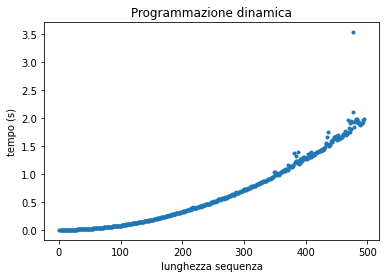

In [75]:
import matplotlib.pyplot as plt

plt.plot(x, y, '.')
plt.xlabel("lunghezza sequenza")
plt.ylabel("tempo (s)")
plt.title("Programmazione dinamica")
plt.show()

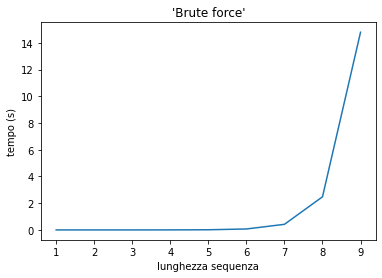

In [81]:
plt.plot(n_brute, t_brute)
plt.xlabel("lunghezza sequenza")
plt.ylabel("tempo (s)")
plt.title("'Brute force'")
plt.show()

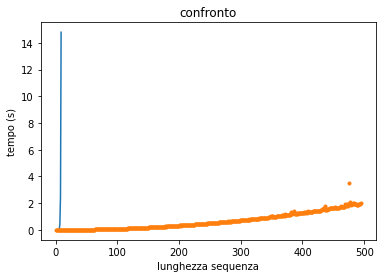

In [84]:
plt.plot(n_brute, t_brute)
plt.plot(x, y, '.')
plt.xlabel("lunghezza sequenza")
plt.ylabel("tempo (s)")
plt.title("confronto")
plt.show()